In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
# from rdkit.Chem.Draw import MolDrawing, DrawingOptions, MolToImage

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

import numpy as np
import pandas as pd
import os

from tqdm.notebook import tqdm
import multiprocessing as mp

import coupling_utils
import molprops_utils

In [2]:
am3 = Chem.MolFromSmarts("[CX4][CX4][NH2]")
am2 = Chem.MolFromSmarts("[CX3]=[CX3][NH2]")
ac3 = Chem.MolFromSmarts("[CX4][CX4][CX3](=O)[OX2H1]")
ac2 = Chem.MolFromSmarts("[CX3][CX3][CX3](=O)[OX2H1]")

group_dict = {"ac2":ac2, "ac3":ac3,"am2":am2,"am3":am3}


# the dictionary is basically like, first entry is amine C1. second entry is amine c2. 
# this changes depending on the matrix, and how the smarts for the matcher is written. 

# number of entries in the amat
amat_indices = range(8)
# which entry each index should map to
eld = [0,1,3,4,5,2,6,7]
# eld = [3,4,5,0,1,2,6,7]


# amat index -> amine/acid match index
amat2ind = {k:v for k,v in zip(amat_indices, eld)}
ind2amat = {v:k for k,v in zip(amat_indices, eld)}

bond_dict = {1:Chem.BondType.SINGLE, 2:Chem.BondType.DOUBLE, 3:Chem.BondType.TRIPLE}


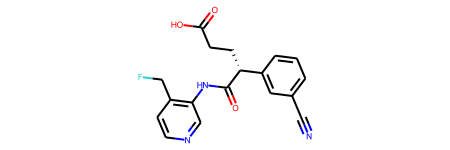

In [3]:
acid_smiles = "O=C([C@@H](C1=CC(C#N)=CC=C1)CCC(O)=O)NC2=C(CF)C=CN=C2"
acid = Chem.MolFromSmiles(acid_smiles)
acid

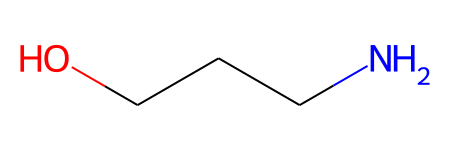

In [4]:
amine = Chem.MolFromSmiles("OCCCN")
amine

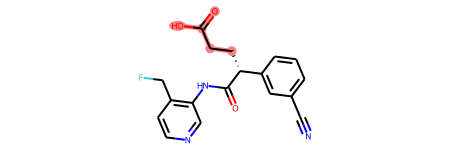

In [5]:
acid.GetSubstructMatch(ac3)
acid

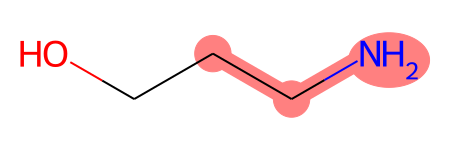

In [6]:
amine.GetSubstructMatch(am3)
amine

In [7]:
both = Chem.CombineMols(acid,amine)
Chem.Kekulize(both,clearAromaticFlags=True)

In [8]:
# get the indices for the acid and amine matches.

acid_atoms = both.GetSubstructMatch(group_dict["ac3"])
amine_atoms = both.GetSubstructMatch(group_dict["am3"])

In [9]:
atom_list = amine_atoms + acid_atoms

starting_numHs = np.zeros(8)
for i_at, atom_ind in enumerate(atom_list):
    a = both.GetAtomWithIdx(atom_ind)
    
    print(a.GetSymbol(),a.GetTotalNumHs())
    starting_numHs[ind2amat[i_at]]=int(a.GetTotalNumHs())

C 2
C 2
N 2
C 2
C 2
C 0
O 0
O 1


In [10]:
starting_numHs

array([2., 2., 2., 2., 0., 2., 0., 1.])

In [11]:
if not os.path.exists("./MPro_products"):
    os.makedirs("./MPro_products")

In [12]:
map_input = [[i,acid,amine,starting_numHs] for i in range(56)]

In [13]:
is_demo=False


In [14]:
if __name__ == '__main__':
    with mp.Pool(32) as p:
        if is_demo:
            result = p.starmap(coupling_utils.run_enumeration_demo, map_input,chunksize=1)
        else:
            result = p.starmap(coupling_utils.run_enumeration, map_input,chunksize=1)

In [15]:
def count_atoms(s):
    alphab = "CONcon"
    return len([i for i in s if i in alphab])     

def check_smiles(s):
    # just check for F
    
    coupled_smiles = []
    split_smiles = s.split(".")
    
    for ss in split_smiles:
        if (ss.count("F") == 1):
            coupled_smiles.append(ss)
    if len(coupled_smiles) == 0:
        return "C"
    
    else:
        atom_counts = [count_atoms(s) for s in coupled_smiles]
        largest_frag_ind = np.argmax(atom_counts)
        return coupled_smiles[largest_frag_ind]

In [16]:
all_coupling_data = []

for file_ind in tqdm(range(56)):
    
    file_tag = str(file_ind).zfill(2)
    
    distance_data = pd.read_csv(f"../data_files/smiles_with_all_dists/smiles_with_all_dists_{file_tag}.csv")
    coupling_data = pd.read_csv(f"./MPro_products/MPro_{file_tag}.csv")

    raw_tags = list(coupling_data.rmat_tag - file_ind*1000000)
    coupling_dists = list(distance_data.iloc[raw_tags].ac3_am3)

    coupling_data["distance"] = coupling_dists


    largest_frag = []
    for s in coupling_data.pdt_smiles:
        largest_frag.append(check_smiles(s))
    coupling_data["largest_frag"] = largest_frag
    
    # remove duplicates
    coupling_data.sort_values("distance",inplace=True)
    coupling_data.drop_duplicates(subset="largest_frag",inplace=True)
    coupling_data.sort_values("rmat_tag",inplace=True)


    all_coupling_data.append(coupling_data)

  0%|          | 0/56 [00:00<?, ?it/s]

In [17]:
def clean_smiles(s):
    repl = {"F":"","()":""}
    
    temp = s[:]
    
    for rep in repl:
        temp = temp.replace(rep,repl[rep])
        
    return temp
    

In [18]:
# sort by increasing distance first
all_coupling_df = pd.concat(all_coupling_data)
all_coupling_df.sort_values("distance",inplace=True)
largest_cleaned = [clean_smiles(s) for s in all_coupling_df.largest_frag]
all_coupling_df["largest_cleaned"] = largest_cleaned

# de-duplicate, keeping the one with the lowest coupling distance. 
all_coupling_df.drop_duplicates(subset="largest_cleaned",inplace=True)
all_coupling_df.sort_values("rmat_tag",inplace=True)

all_coupling_df = all_coupling_df[all_coupling_df.largest_frag!="C"].copy()

In [19]:
if __name__ == '__main__':
    with mp.Pool(8) as p:
        bredt_check = p.map(molprops_utils.check_bredt, all_coupling_df.largest_cleaned,chunksize=100)

In [20]:
all_coupling_df["bredt"] = bredt_check
all_coupling_df_bredt = all_coupling_df[all_coupling_df.bredt].copy()
all_coupling_df_bredt.reset_index(drop=True,inplace=True)

In [21]:
all_coupling_df_bredt.rename({"rmat_tag":"Structure_tag","largest_cleaned":"smiles"},axis=1,inplace=True)

In [22]:
all_coupling_df_bredt.head()

,Structure_tag,pdt_smiles,distance,largest_frag,smiles,bredt
0,42061,CCO.COC(C)(N)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1...,7.0,COC(C)(N)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(...,COC(C)(N)OC[C@@H](C(=O)NC1=C(C)C=CN=C1)C1=CC(C...,True
1,42084,CCO.COCCOC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C...,8.0,COCCOC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C#N)=...,COCCOC[C@@H](C(=O)NC1=C(C)C=CN=C1)C1=CC(C#N)=C...,True
2,42105,CCO.COC(CN)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=C...,7.0,COC(CN)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C#...,COC(CN)OC[C@@H](C(=O)NC1=C(C)C=CN=C1)C1=CC(C#N...,True
3,42176,C=C(OC)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C#...,7.0,C=C(OC)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C#...,C=C(OC)OC[C@@H](C(=O)NC1=C(C)C=CN=C1)C1=CC(C#N...,True
4,42218,CCO.COC(=CN)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=...,8.0,COC(=CN)OC[C@@H](C(=O)NC1=C(CF)C=CN=C1)C1=CC(C...,COC(=CN)OC[C@@H](C(=O)NC1=C(C)C=CN=C1)C1=CC(C#...,True


In [23]:
all_coupling_df_bredt[["Structure_tag","distance","smiles"]].to_csv("./MPro_enumerated.csv",index=False)
